# 🏃‍♂️ MediaPipe Pose & Holistic — Hands‑on Notebook
An interactive notebook for **MediaPipe** pipelines. 

1. Run on **your own video** or **web‑cam**.
2. Compare **model types** and **model_complexity**.
3. See impact of **tracking**.

## 📑 Notebook overview
1. **Environment setup** — install & import requirements
2. **Configuration** — set video source and pipeline parameters
3. **Pipeline functions** — create and run the MediaPipe graph
4. **Exercises** — analyse tracking quality and landmark trajectories
5. **Discussion & extras** — reflect on speed/accuracy trade‑offs

## ⚙️ Environment setup

In [1]:
import os, sys, cv2, numpy as np
from pathlib import Path
import mediapipe as mp
from tqdm import tqdm
mp_pose, mp_holistic = mp.solutions.pose, mp.solutions.holistic
mp_draw, mp_styles = mp.solutions.drawing_utils, mp.solutions.drawing_styles
print('MediaPipe version:', mp.__version__)

MediaPipe version: 0.10.21


In [2]:
# I use these commands to make the notebook interactive and automatically reload modified modules)
%load_ext autoreload
%autoreload 2
%matplotlib inline


## 🔧 Key Parameters — MediaPipe Configuration

Tune these settings to control your pipeline behavior:


| Parameter | Typical values | Explanation |
|-----------|----------------|-------------|
| `VIDEO_SOURCE` | `0` *(webcam)* or `'path/to/video.mp4'` | Input stream |
| `MODEL` | `'pose'` or `'holistic'` | Landmark set: body‑only vs body+hands+face |
| `MODEL_COMPLEXITY` | `0`, `1`, `2` | Accuracy ↑ vs FPS ↓ |
| `ENABLE_TRACKING` | `True` or `False` | Temporal smoothing (reduces jitter, adds lag) |
| `SAVE_OVERLAY` | `True` or `False` | Write MP4 with drawn landmarks |
| `OUTPUT_DIR` | folder path | All artefacts written here |

Experiment with these to balance performance, accuracy, and output needs!


In [3]:
# --- Configuration ---
VIDEO_SOURCE     = 0 #'input_videos/salma_hayek_short.mp4'   # 0 for webcam
MODEL            = 'holistic'   # 'pose' or 'holistic'
MODEL_COMPLEXITY = 1            # 0, 1, 2
ENABLE_TRACKING  = True         # temporal smoothing
SAVE_OVERLAY     = True

OUTPUT_DIR = Path('Mediapipe_results')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

## 🚀 Create Pipeline Functions

In [4]:
def create_pipeline(model: str = 'holistic', model_complexity: int = 1,
                    enable_tracking: bool = True):
    """Return an initialised MediaPipe solution instance.
    Parameters
    ----------
    model : 'pose' | 'holistic'
    model_complexity : 0 | 1 | 2
    enable_tracking : smooth landmarks over time if ``True``
    """
    if model not in {'pose', 'holistic'}:
        raise ValueError("model must be 'pose' or 'holistic'")

    kwargs = dict(
        model_complexity=model_complexity,
        smooth_landmarks=enable_tracking,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5,
        static_image_mode=False,
    )

    if model == 'pose':
        return mp_pose.Pose(**kwargs)
    else:
        kwargs['refine_face_landmarks'] = True
        return mp_holistic.Holistic(**kwargs)

In [5]:
def run_inference(source, model='holistic', model_complexity=1, enable_tracking=True,
                  save_overlay=False, out_dir=OUTPUT_DIR):
    """Run MediaPipe on a video or webcam and return keypoints array.
    Returns
    -------
    kpts : np.ndarray  (n_frames, n_landmarks, 4)
    overlay_path : str | None   path to saved video if ``save_overlay``
    """
    cap = cv2.VideoCapture(source)
    if not cap.isOpened():
        raise RuntimeError(f'Cannot open {source}')

    base = Path(str(source)).stem if isinstance(source, str) else 'webcam'
    overlay_path = out_dir / f"{base}_model_{model}_track_{enable_tracking}_comp_{model_complexity}.mp4"

    writer = None
    if save_overlay:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        fps    = cap.get(cv2.CAP_PROP_FPS) or 25
        w, h   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        writer = cv2.VideoWriter(str(overlay_path), fourcc, fps, (w, h))

    pipe = create_pipeline(model, model_complexity, enable_tracking)
    kpts = []

    with tqdm(total=int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0),
              unit='frame', desc='Processing') as pbar:
        while True:
            ok, frame = cap.read()
            if not ok:
                break
            res = pipe.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

            # Draw landmarks
            if model == 'pose':
                mp_draw.draw_landmarks(
                    frame, res.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                    landmark_drawing_spec=mp_styles.get_default_pose_landmarks_style())
            else:
                mp_draw.draw_landmarks(frame, res.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                                       connection_drawing_spec=mp_styles.get_default_face_mesh_contours_style())
                mp_draw.draw_landmarks(frame, res.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
                mp_draw.draw_landmarks(frame, res.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
                mp_draw.draw_landmarks(frame, res.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                       landmark_drawing_spec=mp_styles.get_default_pose_landmarks_style())

            # Collect keypoints
            frame_k = []
            if res.pose_landmarks:
                frame_k.extend([[lm.x, lm.y, lm.z, lm.visibility] for lm in res.pose_landmarks.landmark])
            if model == 'holistic':
                for hand in (res.left_hand_landmarks, res.right_hand_landmarks):
                    if hand:
                        frame_k.extend([[lm.x, lm.y, lm.z, 1.0] for lm in hand.landmark])
                    else:
                        frame_k.extend([[0, 0, 0, 0]] * 21)
            kpts.append(frame_k)

            if writer:
                writer.write(frame)
            cv2.imshow('MediaPipe', frame)
            if cv2.waitKey(1) & 0xFF == 27:  # ESC key
                break
            pbar.update(1)

    cap.release(); cv2.destroyAllWindows()
    cv2.waitKey(1)
    if writer:
        writer.release()

    kpts = np.array(kpts, dtype=np.float32)
    # use the parameters in the name of the output file
    np.save(out_dir / f'{base}_model_{model}_track_{enable_tracking}_comp_{model_complexity}_kpts.npy', kpts)
    return kpts, (str(overlay_path) if save_overlay else None)

## 📝 Exercise 1: Your video or webcam
Set parameters below and run. Press **ESC** to stop.

In [ ]:
VIDEO_SOURCE = "input_videos/salma_hayek_short.mp4"          # 0 for webcam or 'my_video.mp4' (specify the path to your video file)
OUTPUT_BASE_NAME = 'webcam'  if VIDEO_SOURCE == 0 else Path(VIDEO_SOURCE).stem
MODEL='holistic'        # 'pose' or 'holistic'
MODEL_COMPLEXITY = 0      # 0,1,2
ENABLE_TRACKING=True    # smoothing
SAVE_OVERLAY=True

kpts, overlay = run_inference(VIDEO_SOURCE, MODEL, MODEL_COMPLEXITY,
                              ENABLE_TRACKING, SAVE_OVERLAY)
print('Keypoints shape :', kpts.shape)
if overlay: print('Overlay saved to', overlay)

I0000 00:00:1750713176.634927 23312738 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M3 Pro
Processing:   0%|          | 0/1136 [00:00<?, ?frame/s]W0000 00:00:1750713176.696056 23324942 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1750713176.702922 23324942 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1750713176.704035 23324950 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1750713176.704043 23324942 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1750713176.704060 23324947 inference_feedback_manager.cc:114] Feedback manager requi

Keypoints shape : (301, 75, 4)
Overlay saved to Mediapipe_results/salma_hayek_short_model_holistic_track_True_comp_0.mp4


## 📝 Exercise 2 — Model Complexities
Repeat Exercise 1 with `MODEL_COMPLEXITY = 2`. You’ll look at the right thumb’s x-coordinate to quantify jitter (frame-to-frame variance) :
```python
1. Load both keypoint `.npy` files (code below).
2. Plot the x‑trajectory of the **right thump** landmark for each run.
3. Compute frame‑to‑frame Δx mean ± SD.
4. Discuss how smoothing affects variance and latency.

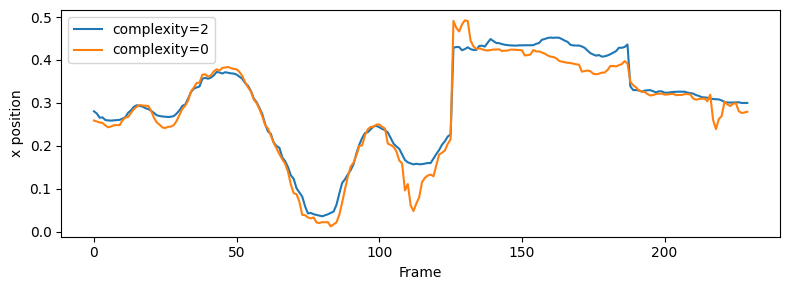

In [17]:
# --- Trajectory comparison ---
import matplotlib.pyplot as plt
MODEL = 'holistic'    # or 'pose'
DIR = 'Mediapipe_results'
# Paths to the two runs
path_large = f'{DIR}/{OUTPUT_BASE_NAME}_model_{MODEL}_track_True_comp_2_kpts.npy'
path_small = f'{DIR}/{OUTPUT_BASE_NAME}_model_{MODEL}_track_True_comp_0_kpts.npy'

kpts_large = np.load(path_large)   # model_complexity=2
kpts_small = np.load(path_small)   # model_complexity=0

# Landmark index for RIGHT_THUMB
if MODEL == 'pose':
    thumb_idx = mp.solutions.pose.PoseLandmark.RIGHT_THUMB.value
else:
    thumb_idx = mp.solutions.holistic.PoseLandmark.RIGHT_THUMB.value

# Trim to same length
n = min(len(kpts_large), len(kpts_small))
kpts_large = kpts_large[:n]
kpts_small = kpts_small[:n]
t = np.arange(n)

# Plot the x-coordinate over time
plt.figure(figsize=(8,3))
plt.plot(t, kpts_large[:, thumb_idx, 0], label='complexity=2')
plt.plot(t, kpts_small[:, thumb_idx, 0], label='complexity=0')
plt.xlabel('Frame')
plt.ylabel('x position')
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
# Differences between consecutive frames
dx_large = np.diff(kpts_large[:, thumb_idx, 0])
dx_small = np.diff(kpts_small[:, thumb_idx, 0])

# Mean and SD of absolute frame-to-frame changes
stats = {
    'complexity_2_mean':  np.mean(np.abs(dx_large)),
    'complexity_2_sd':    np.std(dx_large),
    'complexity_0_mean':np.mean(np.abs(dx_small)),
    'complexity_0_sd':  np.std(dx_small),
}
print("Frame-to-frame |Δx| (mean ± SD):")
print(f"  Complexity 2  : {stats['complexity_2_mean']:.5f} ± {stats['complexity_2_sd']:.5f}")
print(f"  Complexity 0: {stats['complexity_0_mean']:.5f} ± {stats['complexity_0_sd']:.5f}")


Frame-to-frame |Δx| (mean ± SD):
  Complexity 2  : 0.00625 ± 0.01663
  Complexity 0: 0.00941 ± 0.02241


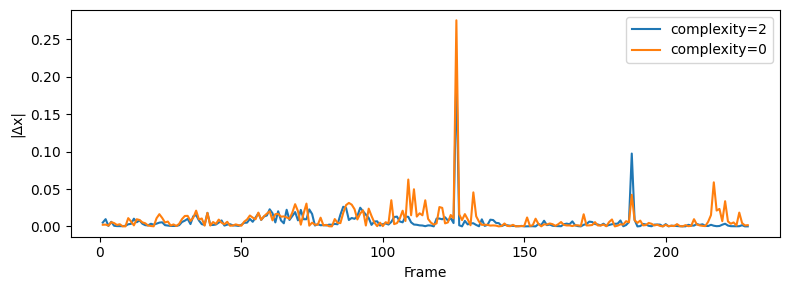

In [20]:
# Plot jitter
plt.figure(figsize=(8,3))
plt.plot(t[1:], np.abs(dx_large),   label='complexity=2')
plt.plot(t[1:], np.abs(dx_small),   label='complexity=0')
plt.xlabel('Frame')
plt.ylabel('|Δx|')
plt.legend()
plt.tight_layout()
plt.show()


## 📝 Exercise 3 (OPTIONAL) — Landmark Indices & Trajectories
Use `mp_pose.PoseLandmark` and `mp_holistic.HandLandmark` to list indices, then plot trajectories of selected landmarks (e.g., **NOSE**, **LEFT_WRIST**, **RIGHT_WRIST**). 

**Solution** is provided below.


1. List all pose and hand landmark indices:  
<details>
<summary>▶️ Show landmark-indices code</summary>

```python
from pprint import pprint
pprint({i: lm.name for i, lm in enumerate(mp_pose.PoseLandmark)})
pprint({i: lm.name for i, lm in enumerate(mp_holistic.HandLandmark)})
```


2. Choose three landmarks (e.g., NOSE, LEFT_WRIST, RIGHT_WRIST) and Extract their 2D trajectories from `kpts` and plot over time:  

<details>
<summary>▶️ Choose and draw landmark-trajectories code (copy to code cell)</summary>

```python
import matplotlib.pyplot as plt

# example indices
nose_idx = mp_pose.PoseLandmark.NOSE.value
lw_idx   = mp_pose.PoseLandmark.LEFT_WRIST.value
rw_idx   = mp_pose.PoseLandmark.RIGHT_WRIST.value

t = np.arange(kpts.shape[0])
for idx, label in [(nose_idx,'Nose'), (lw_idx,'L-Wrist'), (rw_idx,'R-Wrist')]:
        x, y = kpts[:, idx, :2].T
        plt.plot(t, x, label=f'{label} x')
        plt.plot(t, y, '--', label=f'{label} y')
plt.xlabel('Frame'); plt.ylabel('Normalized coord'
plt.legend(); plt.show()
```

## 🧐 Discussion

- **Model Complexity Trade-off**  
   - Complexity 0 vs 1 vs 2: how does inference **FPS** change?  
      • Measure end-to-end runtime on the provided clip by checking how much time it takes to process the entire video. 
   - Does higher complexity give **more accurate** landmarks?  
      • Visually inspect overlay at key joints  

- **Holistic vs Pose-Only**  
   - **Landmark count**: Pose-only returns ~33 landmarks; Holistic adds ~468 face + 42 hands.  

- **Keypoints Array Structure**  
   - Shape: `(n_frames, n_landmarks, 4)` → `(frame, [x, y, z, visibility])`.  
   - Visibility: **NOTE**: MediaPipe does not provide a confidence score for each landmark, but visibility indicates if the landmark is detected (1.0) or not (0.0). **This is only available for pose landmarks, not hands or face landmarks**.

## 📝 Gesture Segmentation Subset

For gesture segmentation, we only need a handful of pose- and all hand-landmarks from the Holistic model. The code below already extracts these and saves them in a `.npy` file.

Please run the code and check the overlay video to see how the landmarks are extracted. We already selected the best parameters for this task. 

In [29]:
MODEL_COMPLEXITY

1

In [30]:
from utils.extract_mp_pose import extract_keypoints
# Path to the video you want to analyse
video_path = "input_videos/salma_hayek_short.mp4"  # or specify a path to your video file
# video_path = 0 # ← use this to use your webcam as input

# Extract keypoints. The function returns a dictionary with useful metadata.
pose_data = extract_keypoints(
    vidf=video_path,
    save_video=True,
    visualize=True,
    model_complexity=2
)

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
I0000 00:00:1750694496.894355 23172773 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M3 Pro


Video resolution: 1920.0x1080.0, FPS: 29.97002997002997
Number of frames in the video: 1136


Processing frames:   0%|          | 0/1136 [00:00<?, ?frame/s]W0000 00:00:1750694496.954247 23197248 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1750694496.977637 23197249 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1750694496.978807 23197258 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1750694496.978847 23197251 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1750694496.978918 23197259 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1750694496.